In [1]:
# Indexing is the process of preparing and organizing data (like documents, web pages, or text chunks) so that it can be efficiently searched and retrieved later.

In [2]:
from dotenv import load_dotenv

load_dotenv()  # load environment variables

True

### Problem Statement

RAG systems rely on effective indexing. Weak indexing can bury relevant content, omit key context, or fragment meaning—leading to incomplete or misleading results.

**Example:**

User query:
- "How do I reset my password?"

Problem:
- The document containing the answer says: “Click ‘Forgot Password’ on the login screen.”
- But the phrase “reset your password” doesn't appear anywhere in the text.

Potential bad outcome:
- The retriever misses the relevant document.
- The LLM responds: “Sorry, I couldn’t find anything about that,” even though the answer exists in the corpus.

### Strategy #1: Chunking Optimization

**Idea**:

[Chucking Visualizer](https://chunkviz.up.railway.app/)

In [3]:
# Do setup for chunking optimization here

from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter, MarkdownTextSplitter, \
    PythonCodeTextSplitter, Language

small_text = "This is the text I would like to chunk up. It is the example text for this exercise"
big_text = """
What is Lorem Ipsum?

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Why do we use it?

It is a long established fact that a reader will be distracted by the readable content of a page when looking at its layout. The point of using Lorem Ipsum is that it has a more-or-less normal distribution of letters, as opposed to using 'Content here, content here', making it look like readable English. Many desktop publishing packages and web page editors now use Lorem Ipsum as their default model text, and a search for 'lorem ipsum' will uncover many web sites still in their infancy. Various versions have evolved over the years, sometimes by accident, sometimes on purpose (injected humour and the like).
"""
markdown_text = """
# Fun in California

## Driving

Try driving on the 1 down to San Diego

### Food

Make sure to eat a burrito while you're there

## Hiking

Go to Yosemite
"""
python_text = """
class Person:
    def __init__(self, name, age):
        self.name = name
        self.age = age

p1 = Person("John", 36)

for i in range(10):
    print(i)
"""

#### Chunking Strategy #1: Character-Level

**Character splitting** simply divides the text into **N-character sized chunks** regardless of their content or form. This is the most basic form of splitting up text.

In [4]:
# Let's trivially chunk the text ourselves

chunks = []
chunk_size = 35  # Characters

for i in range(0, len(small_text), chunk_size):
    chunk = small_text[i:i + chunk_size]
    chunks.append(chunk)

chunks

['This is the text I would like to ch',
 'unk up. It is the example text for ',
 'this exercise']

In [5]:
# We can also use LangChain's CharacterTextSplitter to achieve the same thing

text_splitter = CharacterTextSplitter(chunk_size=35, chunk_overlap=0, separator='', strip_whitespace=False)
docs = text_splitter.create_documents([small_text])

list(map(lambda doc: doc.page_content, docs))

['This is the text I would like to ch',
 'unk up. It is the example text for ',
 'this exercise']

In [6]:
# With LangChain, we can also specify the chunk overlap, which is the amount we'd like our sequential
# chunks to overlap. This helps preserve context between adjacent chunks.

text_splitter = CharacterTextSplitter(chunk_size=35, chunk_overlap=5, separator='', strip_whitespace=False)
docs = text_splitter.create_documents([small_text])

list(map(lambda doc: doc.page_content, docs))

['This is the text I would like to ch',
 'to chunk up. It is the example text',
 ' text for this exercise']

#### Chunking Strategy #2: Character-Level

**Recursive character splitting** breaks the text into smaller chunks *recursively*, based on a *prioritized list of separators.*

It tries to split the text using a list of delimiters (like `"\n\n"`, `"\n"`, `"."`, `" "`, etc.), starting from the *largest* logical unit (like paragraphs) and falling back to smaller ones (like sentences or words) *only if needed*.

In [7]:
# Let's try out RecursiveCharacterTextSplitter in LangChain. Note that:
#  - We no longer break words
#  - We break paragraphs
#  - We still break on sentences, which messes with semantics

text_splitter = RecursiveCharacterTextSplitter(chunk_size=65, chunk_overlap=0)
docs = text_splitter.create_documents([big_text])

list(map(lambda doc: doc.page_content, docs))

['What is Lorem Ipsum?',
 'Lorem Ipsum is simply dummy text of the printing and typesetting',
 "industry. Lorem Ipsum has been the industry's standard dummy",
 'text ever since the 1500s, when an unknown printer took a galley',
 'of type and scrambled it to make a type specimen book. It has',
 'survived not only five centuries, but also the leap into',
 'electronic typesetting, remaining essentially unchanged. It was',
 'popularised in the 1960s with the release of Letraset sheets',
 'containing Lorem Ipsum passages, and more recently with desktop',
 'publishing software like Aldus PageMaker including versions of',
 'Lorem Ipsum.',
 'Why do we use it?',
 'It is a long established fact that a reader will be distracted',
 'by the readable content of a page when looking at its layout.',
 'The point of using Lorem Ipsum is that it has a more-or-less',
 "normal distribution of letters, as opposed to using 'Content",
 "here, content here', making it look like readable English. Many",
 'deskt

#### Chunking Strategy #3: Document Specific

Document-specific splitting tailors the chunking strategy based on the structure or format of the document type — instead of using a one-size-fits-all method.

Different documents have different natural boundaries:
- PDFs → pages or headers
- HTML → tags like `<p>`, `<h1>`
- Markdown → sections like `## Heading`, `` ```js ``, `---`
- JSON → objects/arrays
- Code → functions or classes

In [8]:
# Let's chunk Markdown text

text_splitter = MarkdownTextSplitter(chunk_size=40, chunk_overlap=0)
docs = text_splitter.create_documents([markdown_text])

list(map(lambda doc: doc.page_content, docs))

['# Fun in California\n\n## Driving',
 'Try driving on the 1 down to San Diego',
 '### Food',
 "Make sure to eat a burrito while you're",
 'there',
 '## Hiking\n\nGo to Yosemite']

In [9]:
# Let's chunk Python code

text_splitter = PythonCodeTextSplitter(chunk_size=100, chunk_overlap=0)
docs = text_splitter.create_documents([python_text])

list(map(lambda doc: doc.page_content, docs))

['class Person:\n    def __init__(self, name, age):\n        self.name = name\n        self.age = age',
 'p1 = Person("John", 36)\n\nfor i in range(10):\n    print(i)']

In [10]:
# We can do the same thing using RecursiveCharacterTextSplitter.from_language(...)

text_splitter = RecursiveCharacterTextSplitter.from_language(language=Language.PYTHON, chunk_size=100, chunk_overlap=0)
docs = text_splitter.create_documents([python_text])

list(map(lambda doc: doc.page_content, docs))

['class Person:\n    def __init__(self, name, age):\n        self.name = name\n        self.age = age',
 'p1 = Person("John", 36)\n\nfor i in range(10):\n    print(i)']

In [31]:
# We can chunk PDF files too using "unstructured".
#  - To start out, let's just pull all the tables out of a PDF.

from unstructured.partition.pdf import partition_pdf
from unstructured.documents.elements import Table

filename = "rsc/q1-report.pdf"
elements = partition_pdf(
    filename=filename,
    languages=["eng"],
    strategy="hi_res",
    infer_table_structure=True,
    model_name="yolox",
)
tables = [el for el in elements if isinstance(el, Table)]

tables[0].metadata.text_as_html

'<table><thead><tr><th>Revenue</th><th>$8.51 - $8.53 Billion</th><th>$34.5 - $34.7 Billion</th></tr></thead><tbody><tr><td>Y/Y Growth</td><td>~10%</td><td>~10%</td></tr><tr><td>FX Impact)</td><td>no impact</td><td>no impact</td></tr><tr><td>GAAP Operating Margin</td><td>N/A</td><td>~11.4%</td></tr><tr><td>Non-GAAP Operating Margin?)</td><td>N/A</td><td>~28.0%</td></tr><tr><td>GAAP Earnings per Share?)</td><td>$0.79 - $0.80</td><td>$2.67 - $2.69</td></tr><tr><td>Non-GAAP Earnings per Share()</td><td>$1.89 - $1.90</td><td>$7.41 - $7.43</td></tr><tr><td>Operating Cash Flow Growth (Y/Y)°)</td><td>N/A</td><td>16% - 17%</td></tr><tr><td>Current Remaining Performance Obligation Growth (Y/Y)</td><td>~10%</td><td>N/A</td></tr></tbody></table>'

In [54]:
# By passing a few more flags, we can get unstructured to chunk multi-modal pdf data.
#  - We get back a list of CompositeElements, each one representing a multimodal chunk of our pdf.
#    - CompositeElements can contain text, tables, images, etc.
#  - All images from the pdf are extracted and stored in a folder for later reference.

raw_pof_elements = partition_pdf(
    filename="rsc/white-paper.pdf",
    languages=["eng"],
    extract_images_in_pdf=True,
    infer_table_structure=True,

    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    # Hard max on chunks
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir="rsc/out",
)

raw_pof_elements

In [86]:
# We can access a CompositeElement's ".metadata.orig_elements" to list the elements that make it up.
# We can use a CompositeElement's ".text" to get the concatenation of all text from its children.

composite_elem = raw_pof_elements[3]
orig_elements = composite_elem.metadata.orig_elements

orig_elements, composite_elem.text

([<unstructured.documents.elements.Title at 0x3b1f43930>,
 '3 GPT-assisted Visual Instruction Data Generation\n\nThe community has witnessed a surge in the amount of public multimodal data such as image-text pairs, ranging from CC [8] to LAION [45]. However, when it comes to multimodal instruction-\n\n2\n\nContext type 1: Captions\n\nA group of people standing outside of a black vehicle with various luggage. Luggage surrounds a vehicle in an underground parking area People try to fit all of their luggage in an SUV. The sport utility vehicle is parked in the public garage, being packed for a trip Some people with luggage near a van that is transporting it. Context type 2: Boxes person: [0.681, 0.242, 0.774, 0.694], backpack: [0.384, 0.696, 0.485, 0.914], suitcase: ...<omitted>')

'rsc/out/figure-3-1.jpg'

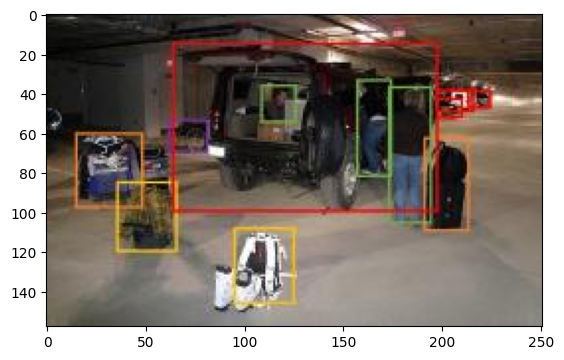

In [82]:
# Images are not included in the CompositeElement's ".text".
#   - To handle images, we can select them from ".metadata.orig_elements" and get things like "image_path" from them.
#   - From there, we can get embeddings from the images via:
#       - Passing the image to CLIP, which handles embedding both images and text.
#       - Generating a summary of the image and embedding that summary.
#           - There's an example of how to do this in "langchain_rag.ipynb"

from PIL import Image as PILImage
import matplotlib.pyplot as plt

image_path = orig_elements[-1].metadata.image_path
pil_img = PILImage.open(image_path)
plt.imshow(pil_img)

image_path

#### Chunking Strategy #4: Semantic

**Semantic splitting** breaks the text into meaningful units based on its *semantic content* (i.e., meaning), rather than using arbitrary rules like character count or number of sentences.

In [ ]:
# Idea: use sentence embeddings to detect topic shifts.

# 1. Split text into sentences (e.g., with nltk.sent_tokenize or spaCy).
# 2. Convert each sentence (or small group of sentences) into embeddings using an embedding model.
# 3. Slide a window across sentence embeddings and compute cosine similarity between adjacent windows.
# 4. If similarity drops below a threshold, start a new chunk.

![Image](rsc/jupyter/semantic_chunking.png)

#### Chunking Strategy #5: Agentic

Agentic splitting is a text chunking strategy where an AI agent (often a language model) is asked to intelligently decide how to split a document into meaningful sections.

_The key idea here is that we can get the LLM to split the text for us._

In [101]:
# Import all the stuff we'll need

from typing import Optional, List
from pydantic import BaseModel, Field
from langchain.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core. runnables import RunnableLambda
from langchain.chains import create_extraction_chain
from langchain.chains import create_extraction_chain_pydantic
from langchain import hub

In [110]:
# Create a chain to feed a text-splitting prompt to an LLM that outputs structured data representing
# the sentence splits. The prompt asks the LLM to create "propositions", statements that can stand on
# their own and don't need any external context.

class Sentences(BaseModel):
    sentences: List[str] = Field(
        ...,
        description="Given a compound sentence, split it into simple sentences.",
    )

llm = ChatOllama(model="llama3.2:1b")
structured_llm = llm.with_structured_output(Sentences)

prompt = hub.pull("wfh/proposal-indexing")
chain = prompt | structured_llm

chain

ChatPromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'wfh', 'lc_hub_repo': 'proposal-indexing', 'lc_hub_commit_hash': 'd962e1728e4cb8a6c7f0aa05522c4102fc8c941c20a6915ff3b7f243cca93943'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='Decompose the "Content" into clear and simple propositions, ensuring they are interpretable out of\ncontext.\n1. Split compound sentence into simple sentences. Maintain the original phrasing from the input\nwhenever possible.\n2. For any named entity that is accompanied by additional descriptive information, separate this\ninformation into its own distinct proposition.\n3. Decontextualize the proposition by adding necessary modifier to nouns or entire sentences\nand replacing pronouns (e.g., "it", "he", "she", "they", "this", "that") with the full name of the\nentities they refer to.\n4. Present the results as a list of 

In [114]:
# Now lets take our LLM text splitter for a spin
#   - We get a list of propositions, matching the main ideas of the original text

chain.invoke({"input": big_text}).sentences

['Lorem Ipsum is simply dummy text of the printing and typesetting industry.',
 'The point of using Lorem Ipsum is that it has a more-or-less normal distribution of letters.',
 'It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages,',
 'Many desktop publishing packages and web page editors now use Lorem Ipsum as their default model text.',
 'The readable content of a page will be distracted by the layout, making it look like readable English.']

In [107]:
# We can then merge these propositions together to create chunks, either with:
#   - Some semantic chunking algorithm, like the one described previously, or
#   - Another LLM agent, that we instruct to merge propositions with similar semantic meaning

# This is an ongoing field of research.

### Strategy #2: Multi-Representation Indexing

![Image](rsc/jupyter/multi_representational_indexing.png)

**Idea**: Instead of storing one embedding per document chunk, you store several, each capturing a different perspective, style, or abstraction level (e.g. original text, LLM short summary, LLM semantic summary, keyword list, etc.).

_**Note**: We'll focus on a simple case of this technique, in which we store a semantic summary of the document in our vector DB and use it to retrieve the original document (which we store separately in a document DB)._

In [109]:
# Let's first pull some documents

from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [116]:
# Let's now generate summaries for our documents

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | ChatOllama(model="llama3.2:1b")
    | StrOutputParser()
)

summaries = chain.batch(docs, {"max_concurrency": 5})

summaries

["This is a long text that appears to be a research paper or document about developing large language models (LLMs) and autonomous agents. It includes various sections, such as introductions, challenges, references, and conclusions.\n\nHere's a summary of the main points:\n\n**Introduction**\n\nThe authors introduce themselves and their work on developing autonomous agents that can interact with the world using natural language processing (NLP). They highlight the importance of LLMs in this field and the need to address various challenges, such as steeringability, prompting, and adversarial attacks.\n\n**Steeringability**\n\nThe authors discuss the concept of steeringability, which refers to an agent's ability to adapt to changing situations and make decisions based on incomplete or uncertain information. They argue that current LLMs struggle with steeringability due to their reliance on explicit instructions and finite context length.\n\n**Prompting**\n\nThe authors investigate variou

In [124]:
# Now the interesting part: Let's implement multi-representational indexing using these documents
# and their corresponding summaries.
#   - We'll store our summaries in a vectorstore, so we can do similarity search (here, we use Chroma)
#   - We'll store our original documents in some docstore (here, we use InMemoryByteStore)
#   - LangChain's MultiVectorRetriever lets us retrieve from a set of multiple embeddings for the same document.

import uuid
from langchain_ollama import OllamaEmbeddings
from langchain.storage import InMemoryByteStore
from langchain_chroma import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever

# Create a MultiVectorRetriever to logically link our summaries and documents
id_key = "doc_id"
vectorstore = Chroma(collection_name="summaries", embedding_function=(OllamaEmbeddings(model="nomic-embed-text")))
docstore = InMemoryByteStore()
retriever = MultiVectorRetriever(
    vectorstore=vectorstore, # stores the summary chunks
    byte_store=docstore,  # stores the original documents
    id_key=id_key,  # group multiple representations under a common identifier
)

# Link each summary to its corresponding document
doc_ids = [str(uuid.uuid4()) for _ in docs]  # generate common doc_id for each document
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})  # bind doc_id to each summary
    for i, s in enumerate(summaries)
]
original_docs = list(zip(doc_ids, docs)) # bind doc_id to each original document

# Add summaries to vectorstore and original documents to docstore
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(original_docs)

retriever

MultiVectorRetriever(vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x3b8665090>, byte_store=<langchain_core.stores.InMemoryByteStore object at 0x3b90cde00>, docstore=<langchain.storage.encoder_backed.EncoderBackedStore object at 0x3b90cdf30>, search_kwargs={})

In [125]:
# Now, when we invoke the vectorstore on a query, we pull out the relevant summaries and ...

query = "Memory in agents"
sub_docs = vectorstore.similarity_search(query, k=1)

sub_docs[0]

Document(id='59087ac0-ca8a-4a8e-ae30-6910b76335ec', metadata={'doc_id': '4d372bb7-3086-45cb-89d0-b4c2d860d9ca'}, page_content="The text appears to be a research paper or article discussing various methods and techniques used in machine learning, artificial intelligence, and data quality control. It covers several topics related to data quality, including:\n\n1. High-Quality Human Data: The authors discuss the importance of high-quality human data for training deep neural networks.\n2. Noisy Cross-Validation (NCV): The paper introduces NCV, a method that divides the dataset into two halves and identifies clean samples as those with correct labels provided by the model trained on one half.\n3. Noisy Data Training: The authors discuss various methods for noisy data training, including:\n\t* AUM (Area Under the Margin) evaluation\n\t* INCV (Iterative Noisy Cross-Validation)\n4. Machine Learning Models and Evaluation Metrics: The paper discusses machine learning models and their performance

In [134]:
# When we invoke the MultiVectorRetriever on a query, we pull out the relevant original documents. Under the hood:
#   1. The query is embedded using the vectorstore's embedding function.
#   2. It retrieves the top-k child chunks (e.g. summaries) that are closest to the query.
#   3. For each matched child chunk, it pulls the id from the metadata (based on your id_key, e.g. "doc_id").
#   4. It uses that ID to retrieve the full parent document from the docstore.

retrieved_docs = retriever.invoke(query, n_results=1)

retrieved_docs[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/', 'title': "Thinking about High-Quality Human Data | Lil'Log", 'description': '[Special thank you to Ian Kivlichan for many useful pointers (E.g. the 100+ year old Nature paper “Vox populi”) and nice feedback. 🙏 ]\nHigh-quality data is the fuel for modern data deep learning model training. Most of the task-specific labeled data comes from human annotation, such as classification task or RLHF labeling (which can be constructed as classification format) for LLM alignment training. Lots of ML techniques in the post can help with data quality, but fundamentally human data collection involves attention to details and careful execution. The community knows the value of high quality data, but somehow we have this subtle impression that “Everyone wants to do the model work, not the data work” (Sambasivan et al. 2021).', 'language': 'en'}, page_content='\n\n\n\n\n\nThinking about High-Quality Human D

### Strategy #3: RAPTOR

![Image](rsc/jupyter/raptor_indexing.png)

**Idea**: Create a hierarchy of documents summaries with high-level summaries at the top of the hierarchy, lower-level summaries in the middle, and the original documents at the bottom. When user queries come in:
- Abstract high-level queries are handled by the high-level and mid-level summaries.
- Specific low-level queries are handled by the original documents.

---

Goals of RAPTOR (Retrieval-Aware Pretraining for Targets of Retrieval)
1. Create meaningful, retriever-friendly chunks (not arbitrary token splits).
2. Organize them hierarchically to reflect document structure.
3. Use LLM-generated summaries to describe higher-level sections.

At index time:
- Chunk documents semantically using heuristics or LLMs.
- Organize chunks into a tree (paragraphs → sections → document).
- Summarize each node with an LLM.
- Index each level’s summary as a separate vector.

At query time:
- You can match the query against all levels.
- Traverse the hierarchy based on relevance.
- Retrieve the most informative chunk(s) at the right level of detail.

In [ ]:
# todo: revisit, implement later
# Reference: https://github.com/langchain-ai/langchain/blob/master/cookbook/RAPTOR.ipynb

### Strategy #4: ColBERT

![Image](rsc/jupyter/colbert_indexing.png)

**Idea**: A fundamentally different algorithm for determining document-query similarity: each token in a query is matched against each token in a document, allowing for more precise and expressive retrieval (fine-grained, late-interaction retrieval).

---

With late interaction, the model doesn't collapse the input into a single vector. Instead:
- Query is encoded into a sequence of token vectors: `q₁, q₂, ..., qₙ`
- Document is encoded into a sequence of token vectors: `d₁, d₂, ..., dₘ`
- You match each query token against each document token, using cosine similarity.

Then, for each query token, you take the maximum similarity across all document tokens (this is the `MaxSim` operation), and sum the results to get the final score.

**Example:**

Query:
- “When did Tesla begin?”

Two document chunks:
1. “Tesla was founded in 2003 by engineers...”
2. “Tesla makes electric vehicles and solar panels.”

In ColBERT:
- "when" in the query might match "2003" in document 1.
- "begin" might match "founded" in document 1.
- These specific token matches dominate the score.